In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [2]:
from houghLines import HoughLines, show_lines, slope_close_to, merge_lines

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from collections import defaultdict

from PIL import Image
from PIL import ImageFilter

In [4]:
ROI_Y_RATIO = 600/2200
BINARY_THRESHOLD = 200

HOUGH_RHO_RES = 1/4
HOUGH_THETA_RES = np.pi/(4*180)
HOUGH_THRESHOLD = 300
VERTICAL_SLOPE_TOL = 15
RHO_MERGE_TOL = 10/1700

BOX_HEIGHT = 25 # needs to be a ratio (25/2200)
YGAP_BETWEEN_BOXES = 18 # needs to be a ratio (18/2200)
WRITTEN_AVG_INTENSITY_THRESH = 4

MIN_AVG_INTENSITY_SHADED_BOX = 160

In [5]:
def preprocess(img, vertical_edges=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    blurred_cropped = blurred[int(ROI_Y_RATIO*gray.shape[0]):, :]
    (T, threshinv) = cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    
    if vertical_edges:
        sobel_kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T
        pf = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel)
        return pf
    return threshinv

In [64]:
img = cv2.imread('../test-images/c-33.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
blurred_cropped = blurred[int(ROI_Y_RATIO*gray.shape[0]):, :]
(T, threshinv) = cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)


img_processed = preprocess(img)

In [28]:
im = Image.open('../test-images/c-33.jpg').convert("L")
np.all(gray == np.asarray(im))

True

In [50]:
ksize=5
sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
sigma

1.1

In [57]:
# https://hhsprings.bitbucket.io/docs/programming/examples/python/PIL/ImageFilter.html

km = np.array((
        (1, 4, 6, 4, 1),
        (4, 16, 24, 16, 4),
        (6, 24, 36, 24, 6),
        (4, 16, 24, 16, 4),
        (1, 4, 6, 4, 1),
      )) / 256.
k = ImageFilter.Kernel(
    size=km.shape,
    kernel=km.flatten(),
    scale=np.sum(km),  # default
    offset=0  # default
    )
im_blur_2 = im.filter(k)

In [58]:
np.sum((blurred - np.asarray(im_blur_2))**2), np.all(blurred == np.asarray(im_blur_2))

(0, True)

In [66]:
def inv_threshold(img, t, lo=0, high=255):
    '''
    Identical to cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    '''
    out = img.copy()
    mask_hi = img > t
    out[mask_hi] = lo
    
    out[~mask_hi] = high
    
    return out

In [67]:
im_cropped = np.asarray(im_blur_2)[int(ROI_Y_RATIO*gray.shape[0]):, :]
n = inv_threshold(im_cropped, 200)

In [68]:
np.all(threshinv == im_inv_thresh)

True

In [69]:
def gaussian_blur(im):
    '''
    Identical to cv2.GaussianBlur(gray, (5, 5), 0)
    '''
    # https://hhsprings.bitbucket.io/docs/programming/examples/python/PIL/ImageFilter.html
    km = np.array((
        (1, 4, 6, 4, 1),
        (4, 16, 24, 16, 4),
        (6, 24, 36, 24, 6),
        (4, 16, 24, 16, 4),
        (1, 4, 6, 4, 1),
      )) / 256.
    k = ImageFilter.Kernel(
        size=km.shape,
        kernel=km.flatten(),
        scale=np.sum(km),  # default
        offset=0  # default
        )
    return im.filter(k)

In [75]:
def preprocess_custom(im):
    gray = im.convert("L")
    blurred = np.asarray(gaussian_blur(gray))
    im_cropped = blurred[int(ROI_Y_RATIO*blurred.shape[0]):, :]
    threshinv = inv_threshold(im_cropped, 200)
    return threshinv

In [76]:
img = cv2.imread('../test-images/c-33.jpg')
im = Image.open('../test-images/c-33.jpg')


np.all(preprocess(img) == preprocess_custom(im))


True

In [81]:
sobel_kernel_h = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
pf_thresh_h = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel_h)

In [85]:
k = ImageFilter.Kernel(
        size=sobel_kernel_h.shape,
        kernel=sobel_kernel_h.flatten(),
        scale=np.sum(sobel_kernel_h),  # default
        offset=0  # default
        )
im_sobel = pil_inv_thresh.filter(k)

In [87]:
np.all(np.asarray(im_sobel) == pf_thresh_h)

False

(array([2622276.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   97724.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

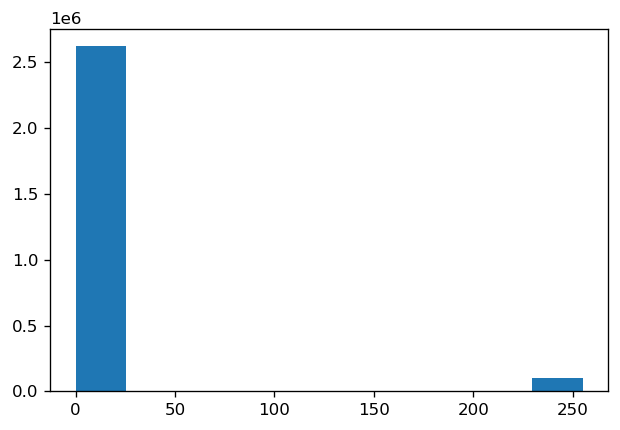

In [90]:
plt.hist(pf_thresh_h.flatten())

(array([      0.,       0.,       0.,       0.,       0., 2720000.,
              0.,       0.,       0.,       0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

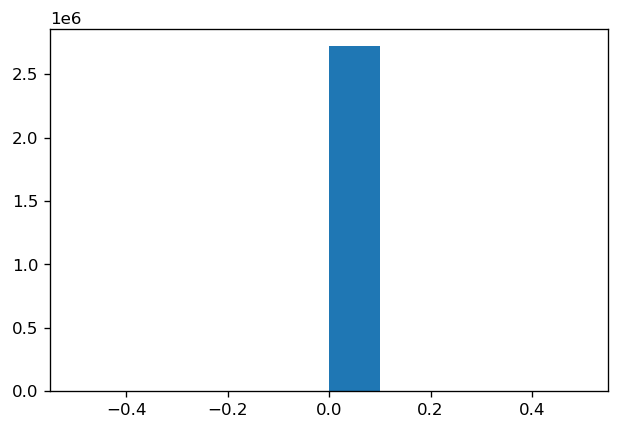

In [89]:
plt.hist((np.asarray(im_sobel).flatten()))

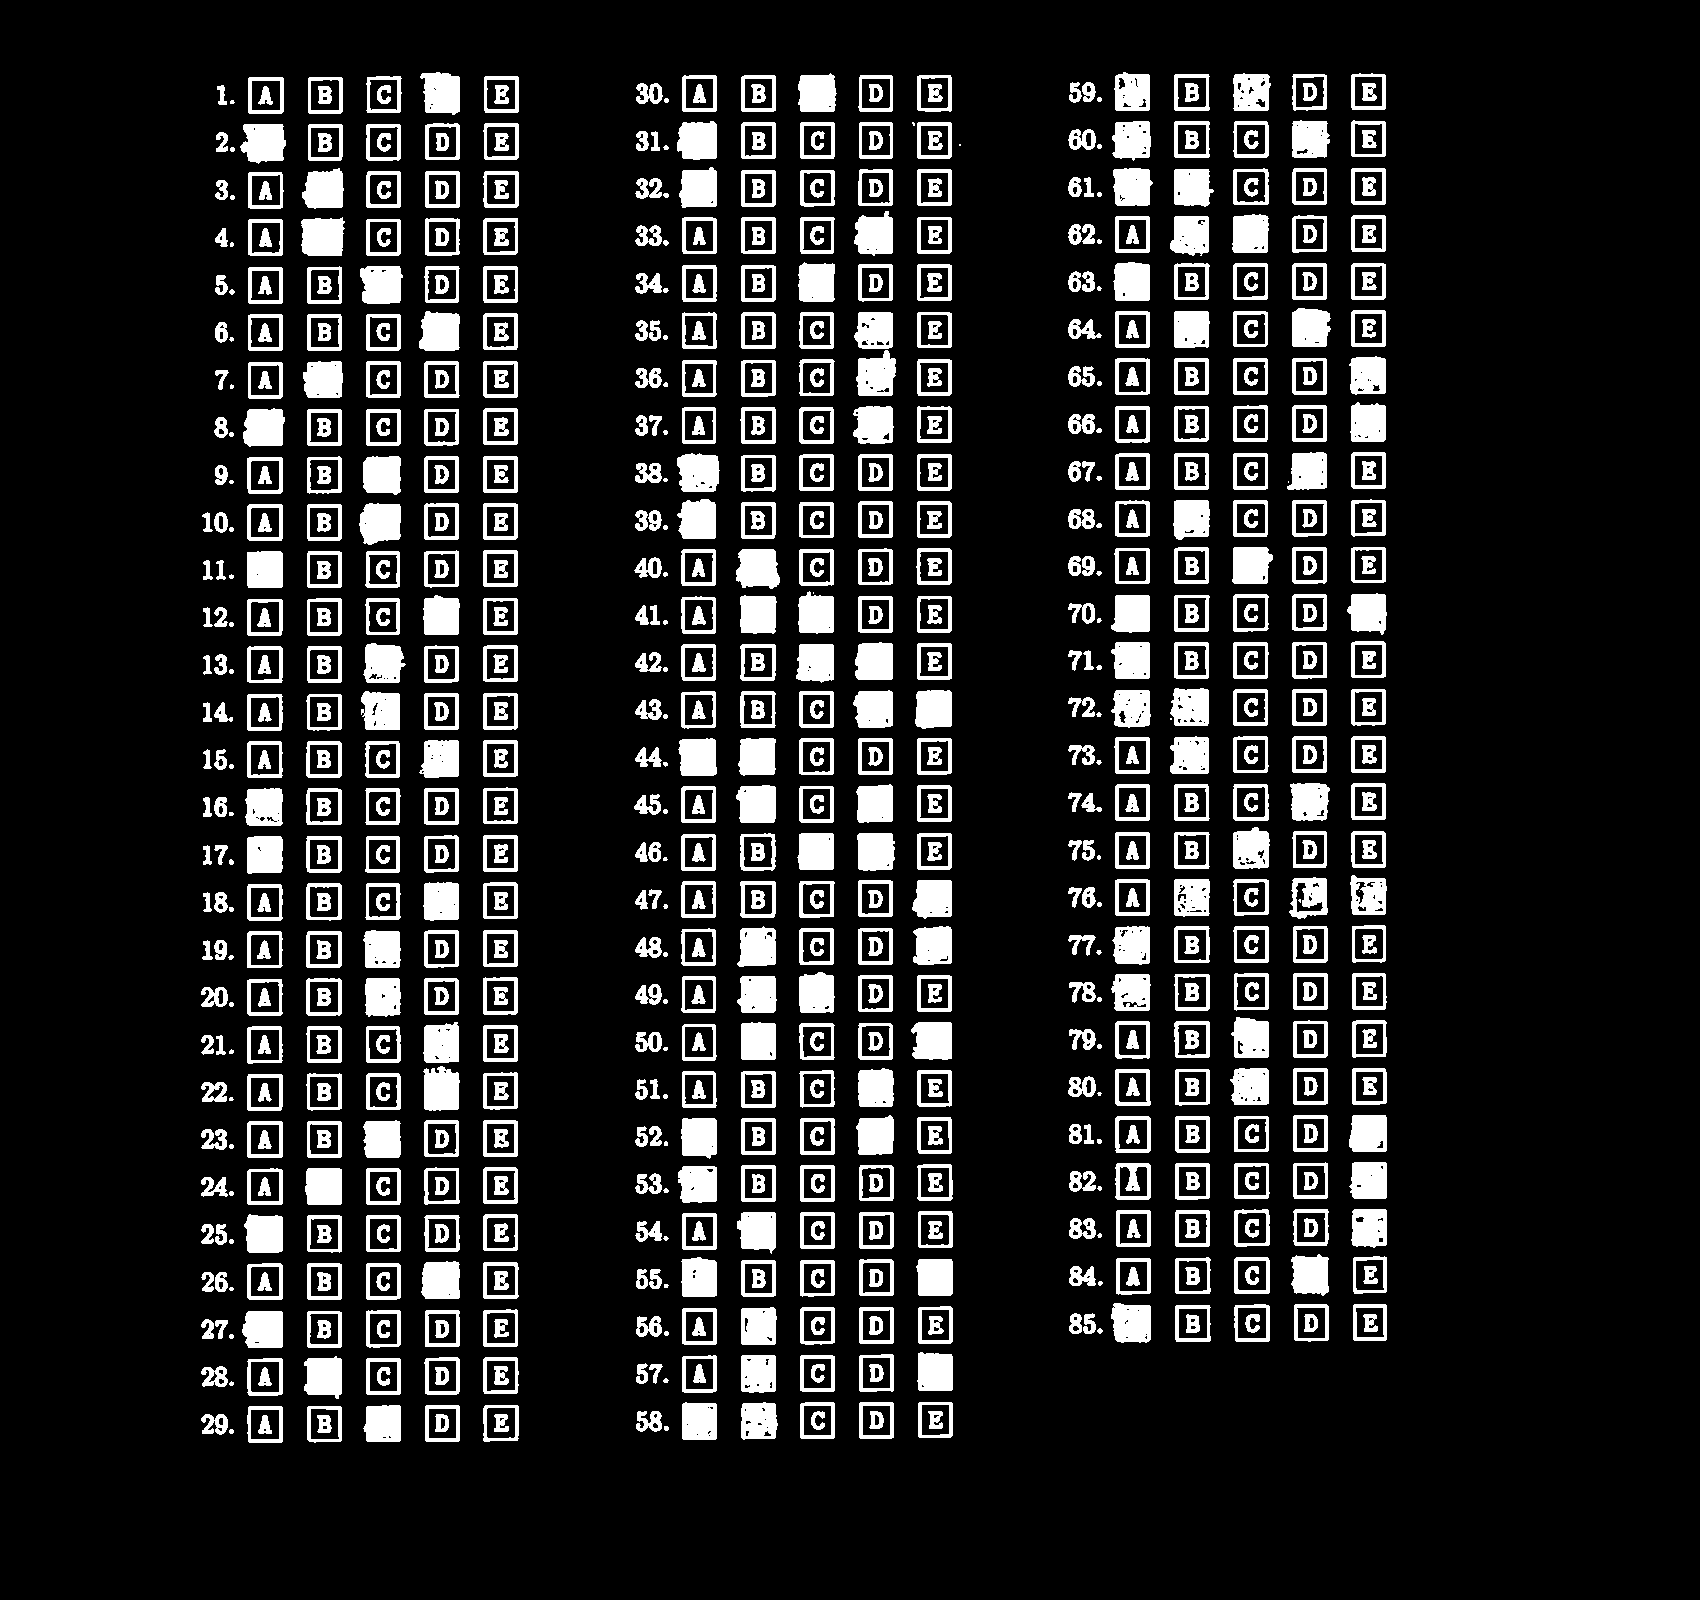

In [84]:
pil_inv_thresh = Image.fromarray(im_inv_thresh)
pil_inv_thresh

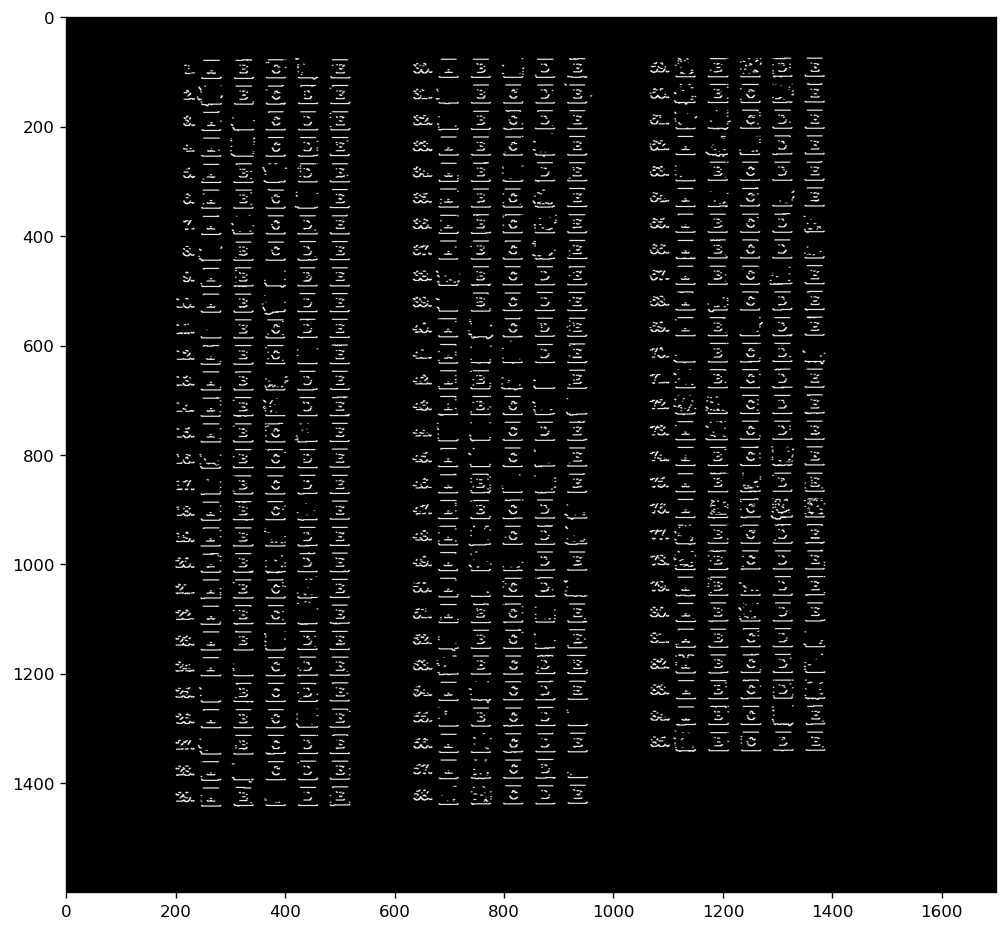

In [82]:
plt.figure(figsize=(10,12))
plt.imshow(pf_thresh_h, cmap='gray')